In [1]:
#This is my model for generation of words on a partially masked corpus of text i.e. Twitch Data

In [2]:
#Utilizing Hugging Face
#https://huggingface.co/docs/transformers/quicktour

#Refs
#https://towardsdatascience.com/how-to-use-bert-from-the-hugging-face-transformer-library-d373a22b0209

**Install Requirements**

In [3]:
# %pip install transformers datasets
# %pip install torch
# %from transformers import EncoderDecoderModel, BertTokenizer
# %pip freeze requirements.txt
# %pip install matplotlib
# %pip install numpy
# %pip install tensorflow
# %pip install scikit-learn


**Imports**

In [1]:
import transformers
import torch
import os
import pandas as pd
import pickle as pkl
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

c:\Users\anish\Projects\twitchBot\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Loading Data**

In [2]:
#Load Raw Data from StreamerData folder
#- Take certain number of files from data folder to use for generation

#Set this to the path of your data
folder_path = 'C:/Users/anish/Projects/twitchBot/streamerdata'

numFiles = 2

data = []

for i, file in enumerate(os.listdir(folder_path)):
    print("Adding file:", file)
    if i == numFiles - 1:
        break  
    with open(os.path.join(folder_path, file), 'rb') as f:
        curr_file = pkl.load(f)
        data.append(curr_file)

all_df = pd.concat(data, axis = 0)

Adding file: admiralbahroo.pkl
Adding file: admiralbulldog.pkl


In [3]:
#Display all_data
display(all_df.head())

#Print data columns
print([i for i in all_df.columns])

#Print size of data
print("Num Rows:", len(all_df))
print("Num Cols:", len(all_df.columns))


,body,channel_id,commenter_id,commenter_type,created_at,fragments,offset,updated_at,video_id
0,STILL LATE STRIMMER IS A BAKA rooBaka STRIMMER...,40972890,110969182,user,2018-06-24T17:07:43.067Z,"[{'text': 'STILL LATE STRIMMER IS A BAKA '}, {...",4.367,2018-06-24T17:07:43.067Z,277073045
1,NOT LIVE rooREE rooREE rooREE,40972890,109856709,user,2018-06-24T17:07:43.168Z,"[{'text': 'NOT LIVE '}, {'emoticon_id': '90487...",4.468,2018-06-24T17:07:43.168Z,277073045
2,rooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooB...,40972890,56159955,user,2018-06-24T17:07:44.631Z,"[{'emoticon_id': '904818'}, {'text': ' BAHROOr...",5.931,2018-06-24T17:07:44.631Z,277073045
3,See,40972890,78678476,user,2018-06-24T17:07:45.602Z,[{'text': 'See'}],6.902,2018-06-24T17:07:45.602Z,277073045
4,rooPog,40972890,30898708,user,2018-06-24T17:07:45.802Z,[{'emoticon_id': '904866'}],7.102,2018-06-24T17:07:45.802Z,277073045


['body', 'channel_id', 'commenter_id', 'commenter_type', 'created_at', 'fragments', 'offset', 'updated_at', 'video_id']
Num Rows: 2722109
Num Cols: 9


**Data Preprocessing**

In [48]:
#Filter Data Frame by Strings that are longer than 3 -> Allow for masking
long_df = all_df[all_df['body'].apply(lambda x: len(x.split(' '))) > 3]

#Use small dataframe for testing efficiency's sake
long_df = long_df.iloc[:100]
print("Number of Rows:", len(long_df))

#Replace certain words with Mask token '[MASK]'
masked_arr = long_df.body.tolist()
for i in range(len(masked_arr)):

    add_mask = masked_arr[i].split(" ")
    mask_index = random.randint(0, len(add_mask) - 1)
    add_mask[mask_index] = '[MASK]'
    masked_arr[i] = " ".join(add_mask)


long_df['masked'] = masked_arr

display(long_df['masked'].head())

Number of Rows: 100


0    STILL [MASK] STRIMMER IS A BAKA rooBaka STRIMM...
1                     [MASK] LIVE rooREE rooREE rooREE
2    rooBaka [MASK] BAHROOrooBaka BAHROOrooBaka BAH...
7           [MASK] rooHappy rooHappy rooHappy rooHappy
8    rooREE LATE rooREE LATE rooREE LATE rooREE LAT...
Name: masked, dtype: object

In [49]:
all_words = []
for i in range(len(long_df['body'])):
    all_words += long_df['body'].iloc[i].split(" ")

**Tokenizing**

In [56]:
import nltk
from gensim.models import KeyedVectors
import string
import numpy as np

similarities = []

# Load a pre-trained word embedding model
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

candidate_words = all_words

for i in range(len(long_df['masked'])):
    # Define the sentence and candidate words
    sentence = long_df['masked'].iloc[i]
    # Tokenize the sentence and remove stop words and punctuation marks
    tokens = nltk.word_tokenize(sentence)
    stop_words = nltk.corpus.stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]

    # Get the vector representation of each token in the sentence
    token_vectors = [model.get_vector(token) for token in tokens if token in model.key_to_index]

    # Calculate the mean vector of all the tokens in the sentence
    if len(token_vectors) > 0:
        sentence_vector = np.mean(token_vectors, axis=0)
    else:
        sentence_vector = np.zeros((model.vector_size,))

    # Calculate cosine similarity for each candidate word
    max_sim = -1
    max_word = None
    for word in candidate_words:
        if word in model.key_to_index:
            word_vector = model.get_vector(word)
            sim = np.dot(sentence_vector, word_vector) / (np.linalg.norm(sentence_vector) * np.linalg.norm(word_vector))
            if sim > max_sim:
                max_sim = sim
                max_word = word

    # Output the mask word
    print(max_word)
    print(max_sim)
    similarities.append(max_sim)

IS
0.83073515
LIVE
0.83370066
TIMER
0.5281348
TIMER
0.5281348
LATE
0.99960655
TIMER
0.5281348
TIMER
0.5281348
LIVE
0.9949451
TIMER
0.5281348
TIMER
0.5281348
TIMER
0.5281348
LATE
0.7753882
LATE
0.9991583
TIMER
0.5281348
new
0.5524459
wait
0.6929407
TIMER
0.5281348
E
0.7583683
TIMER
0.5281348
TIMER
0.5281348
LATE
0.82769924
TIMER
0.5281348
TIMER
0.5281348
TIMER
0.5281348
min
0.6375881
hi
0.78050095
TIMER
0.5281348
ROO
0.7633183
TIMER
0.5281348
TIMER
0.5281348
ARTIST
0.83224005
playing
0.623025
Clap
0.98725635
LATE
0.83747226
hi
0.78050095
TIMER
0.5281348
INTO
0.8391951
TIMER
0.5281348
TIMER
0.5281348
TIMER
0.5281348
Discord
0.5458153
TIMER
0.5281348
TIMER
0.5281348
T
0.85148054
me
0.5813353
TIMER
0.5281348
TIMER
0.5281348
panda
0.7066832
BACK
0.8253149
TIMER
0.5281348
LOL
0.39654866
TIMER
0.5281348
TIMER
0.5281348
TIMER
0.5281348
TIMER
0.5281348
hes
0.7504941
M
0.7365167
host
0.4517543
TIMER
0.5281348
C
0.73538893
TIMER
0.5281348
TIMER
0.5281348
TIMER
0.5281348
wait
0.589137
subs
0.60765

In [57]:
print(sum(similarities) / len(similarities))

0.6222472831606864


Text(0.5, 0, 'Sentence #')

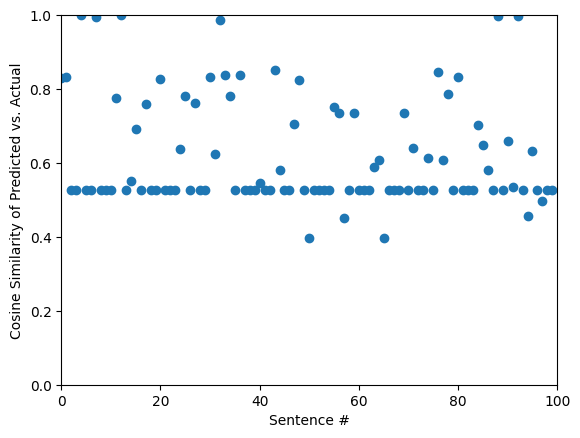

In [58]:
#Display your results!
plt.scatter(range(len(similarities)), similarities)
plt.xlim(0, len(similarities))
plt.ylim(0, 1)
plt.ylabel("Cosine Similarity of Predicted vs. Actual")
plt.xlabel("Sentence #")